# Cluster Lens Simulation Interface

This notebook shows the current progress in the group and cluster scale simulations.

Implemented:
* First draft of the ClusterLens class (handles the lenstronomy parameters)
* Model a lens with a halo and subhaloes (and a single source).
* Halo and subhaloes have EPL mass profile.

Not (yet) implemented:
* Halo with NFW profile
* Draw halo and subhalo population
* Catalog of group and cluster deflectors
* Validate the simulation

In [1]:
from slsim.cluster_lens import ClusterLens
from slsim.lens_pop import LensPop

from astropy.cosmology import FlatLambdaCDM

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.units import Quantity
import copy

draw a population of sources and elliptical deflectors

In [2]:
np.random.seed(1)

# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_type="elliptical",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
)

draw one source

In [3]:
source_dict = gg_lens_pop._sources.draw_source()

manually set EPL halo parameters

In [4]:
halo_dict = dict(
    z=0.4,
    vel_disp=400.0,
    e1_light=0.0,
    e2_light=0.0,
    e1_mass=0.1,
    e2_mass=-0.05,
)

Draw 10 elliptical galaxies as subhaloes and place them randomly

In [5]:
n_subhaloes = 10
z_tolerance = 0.05
n_try = 1000

i = 0
subhaloes_table = []
while (i < n_try) and len(subhaloes_table) < n_subhaloes:
    subhalo = gg_lens_pop._lens_galaxies.draw_deflector()
    if np.abs(subhalo["z"] - halo_dict["z"]) < z_tolerance:
        subhaloes_table.append(subhalo)
subhaloes_table = vstack(subhaloes_table)
subhaloes_table["center_x_mass"] = np.random.normal(0.0, 5.0, n_subhaloes)
subhaloes_table["center_y_mass"] = np.random.normal(0.0, 5.0, n_subhaloes)
subhaloes_table["center_x_light"] = subhaloes_table["center_x_mass"]
subhaloes_table["center_y_light"] = subhaloes_table["center_y_mass"]
len(subhaloes_table)

10

Initialize a ClusterLens object to combine the components into a Lenstronomy model

In [6]:
cluster_lens = ClusterLens(source_dict, halo_dict, subhaloes_table, cosmo)

In [7]:
lenstronomy_components, lenstronomy_kwargs = cluster_lens.lenstronomy_kwargs(band="g")

set the source to the center to asure it is lensed

In [8]:
lenstronomy_kwargs["kwargs_source"][0]["center_x"] = 0.0
lenstronomy_kwargs["kwargs_source"][0]["center_y"] = 0.0

set the colors

In [9]:
# g-band
kwargs_source_mag_g = lenstronomy_kwargs["kwargs_source"]
kwargs_lens_light_mag_g = lenstronomy_kwargs["kwargs_lens_light"]

# r-band
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_r[i]["magnitude"] = subhaloes_table[i]["mag_r"]

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]["magnitude"] = source_dict["mag_r"]

# i-band
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_i[i]["magnitude"] = subhaloes_table[i]["mag_i"]

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]["magnitude"] = source_dict["mag_i"]

Use Lenstronomy sim API to visualize the result

In [10]:
# Instrument setting from pre-defined configurations
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Plots import plot_util

from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.Plots.plot_util import coordinate_arrows, scale_bar


DES_g = DES(band="g", psf_type="GAUSSIAN", coadd_years=3)
DES_r = DES(band="r", psf_type="GAUSSIAN", coadd_years=3)
DES_i = DES(band="i", psf_type="GAUSSIAN", coadd_years=3)
des = [DES_g, DES_r, DES_i]

LSST_g = LSST(band="g", psf_type="GAUSSIAN", coadd_years=10)
LSST_r = LSST(band="r", psf_type="GAUSSIAN", coadd_years=10)
LSST_i = LSST(band="i", psf_type="GAUSSIAN", coadd_years=10)
lsst = [LSST_g, LSST_r, LSST_i]

Roman_g = Roman(band="F062", psf_type="PIXEL", survey_mode="wide_area")
Roman_r = Roman(band="F106", psf_type="PIXEL", survey_mode="wide_area")
Roman_i = Roman(band="F184", psf_type="PIXEL", survey_mode="wide_area")
roman = [Roman_g, Roman_r, Roman_i]

In [11]:
kwargs_model = {
    "lens_model_list": lenstronomy_components[
        "lens_model_list"
    ],  # list of lens models to be used
    "lens_light_model_list": lenstronomy_components[
        "lens_light_model_list"
    ],  # list of unlensed light models to be used
    "source_light_model_list": lenstronomy_components[
        "source_light_model_list"
    ],  # list of extended source models to be used, here we used the interpolated real galaxy
}

In [15]:
from astropy.visualization import ZScaleInterval


def make_zscale_rgb(r, g, b, mask=None, **kwargs):
    if mask is None:
        mask = np.ones(r.shape, dtype=bool)
    zscale = ZScaleInterval(**kwargs)
    rmin, rmax = zscale.get_limits(r[mask])
    gmin, gmax = zscale.get_limits(g[mask])
    bmin, bmax = zscale.get_limits(b[mask])
    rgb = np.dstack(
        (
            (r - rmin) / (rmax - rmin),
            (g - gmin) / (gmax - gmin),
            (b - bmin) / (bmax - bmin),
            mask.astype(float),
        )
    )
    rgb = np.clip(rgb, 0, 1)
    rgb = (rgb * 255.999).astype(np.uint8)
    return rgb

In [16]:
numpix = 200  # number of pixels per axis of the image to be modelled

# here we define the numerical options used in the ImSim module.
# Have a look at the ImageNumerics class for detailed descriptions.
# If not further specified, the default settings are used.
kwargs_numerics = {}


def simulate_rgb(ConfigList, size, kwargs_numerics, contrast=0.1):
    band_b, band_g, band_r = ConfigList
    kwargs_b_band = band_b.kwargs_single_band()
    kwargs_g_band = band_g.kwargs_single_band()
    kwargs_r_band = band_r.kwargs_single_band()

    # set number of pixels from pixel scale
    pixel_scale = kwargs_g_band["pixel_scale"]
    numpix = int(round(size / pixel_scale))

    sim_b = SimAPI(
        numpix=numpix, kwargs_single_band=kwargs_b_band, kwargs_model=kwargs_model
    )
    sim_g = SimAPI(
        numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model
    )
    sim_r = SimAPI(
        numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model
    )

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_b = sim_b.image_model_class(kwargs_numerics)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)

    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_b.magnitude2amplitude(
        kwargs_lens_light_mag_g, kwargs_source_mag_g
    )
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_g.magnitude2amplitude(
        kwargs_lens_light_mag_r, kwargs_source_mag_r
    )
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_r.magnitude2amplitude(
        kwargs_lens_light_mag_i, kwargs_source_mag_i
    )

    image_b = imSim_b.image(
        lenstronomy_kwargs["kwargs_lens"],
        kwargs_source_g,
        kwargs_lens_light_g,
        kwargs_ps_g,
    )
    image_g = imSim_g.image(
        lenstronomy_kwargs["kwargs_lens"],
        kwargs_source_r,
        kwargs_lens_light_r,
        kwargs_ps_r,
    )
    image_r = imSim_r.image(
        lenstronomy_kwargs["kwargs_lens"],
        kwargs_source_i,
        kwargs_lens_light_i,
        kwargs_ps_i,
    )

    # add noise
    image_b += sim_b.noise_for_model(model=image_b)
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)

    img = make_zscale_rgb(image_r, image_g, image_b, contrast=contrast)
    data_class = sim_b.data_class
    return img, data_class

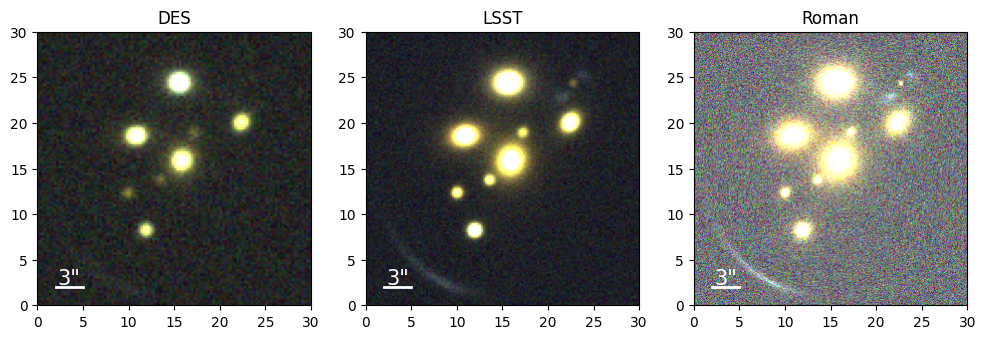

In [17]:
size = 30.0  # width of the image in units of arc seconds

img_des, coords_des = simulate_rgb(
    des, size=size, kwargs_numerics=kwargs_numerics, contrast=0.1
)
img_lsst, coords_lss = simulate_rgb(
    lsst, size=size, kwargs_numerics=kwargs_numerics, contrast=0.1
)
img_roman, coords_roman = simulate_rgb(
    roman, size=size, kwargs_numerics=kwargs_numerics, contrast=0.5
)

f, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.imshow(img_des, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("DES")
# coordinate_arrows(ax, d=1, coords=coords_des, color='w', font_size=15, arrow_size=0.05)
scale_bar(ax, d=size, dist=3.0, text='3"', color="w", font_size=15, flipped=False)

ax = axes[1]
ax.imshow(img_lsst, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("LSST")
scale_bar(ax, d=size, dist=3.0, text='3"', color="w", font_size=15, flipped=False)

ax = axes[2]
ax.imshow(img_roman, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("Roman")
scale_bar(ax, d=size, dist=3.0, text='3"', color="w", font_size=15, flipped=False)
plt.show()